In [2]:
# Supress pytorch pickle load warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Logging
from tqdm import tqdm
import matplotlib.pyplot as plt

# Library imports
import gdiffusion as gd
import util
import util.chem as chem
import util.visualization as vis
import util.stats as gdstats

import gdiffusion.bayesopt as bayesopt
from gdiffusion.classifier.extinct_predictor import EsmClassificationHead
from gdiffusion.classifier.logp_predictor import LogPPredictor

device = util.util.get_device()
print(f"device: {device}")

# peptide diffusion
DIFFUSION_PATH = "saved_models/diffusion/molecule-diffusion-v1.pt"
SELFIES_VAE_PATH = "saved_models/selfies_vae/selfies-vae.ckpt"
SELFIES_VAE_VOCAB_PATH = "saved_models/selfies_vae/vocab.json"
LOGP_PREDICTOR_PATH = "saved_models/logp/model-logp"

/home/alden/miniconda3/envs/pytorch-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


In [ ]:
# Load models and helper functions
_diffusion_model = gd.create_diffusion_model(model_path=DIFFUSION_PATH, device=device)
diffusion = gd.create_ddim_sampler(diffusion_model=_diffusion_model, sampling_timesteps=50)
logp_predictor = torch.load(LOGP_PREDICTOR_PATH).eval().to(device)

# This is to include the automatic reshape option
def sample(batch_size: int, guidance_scale:float = 1.0, cond_fn=None):
    return diffusion.sample(batch_size=batch_size, guidance_scale=guidance_scale, cond_fn=cond_fn).reshape(batch_size, latent_dim)



Model created successfully
- Total parameters: 57,314,049
- Trainable parameters: 57,314,049
- Model size: 218.6 MB
- Device: cuda:0
- Model Name: LatentDiffusionModel
loading model from saved_models/selfies_vae/selfies-vae.ckpt
Enc params: 1,994,592
Dec params: 277,346


In [3]:
selfies_vae = gd.load_vae_selfies(path_to_vae_statedict=SELFIES_VAE_PATH, vocab_path=SELFIES_VAE_VOCAB_PATH)
decode = lambda z: gd.latent_to_smiles(z.float(), vae=selfies_vae)
encode = lambda selfies_str: gd.selfies_to_latent(selfies_str, vae=selfies_vae)

latent_dim = 128
def sample_random(batch_size):
    return torch.randn(size=(batch_size, latent_dim), device=device)

loading model from saved_models/selfies_vae/selfies-vae.ckpt
Enc params: 1,994,592
Dec params: 277,346


DDIM Sampling Loop Time Step: 100%|██████████| 50/50 [00:01<00:00, 41.09it/s]


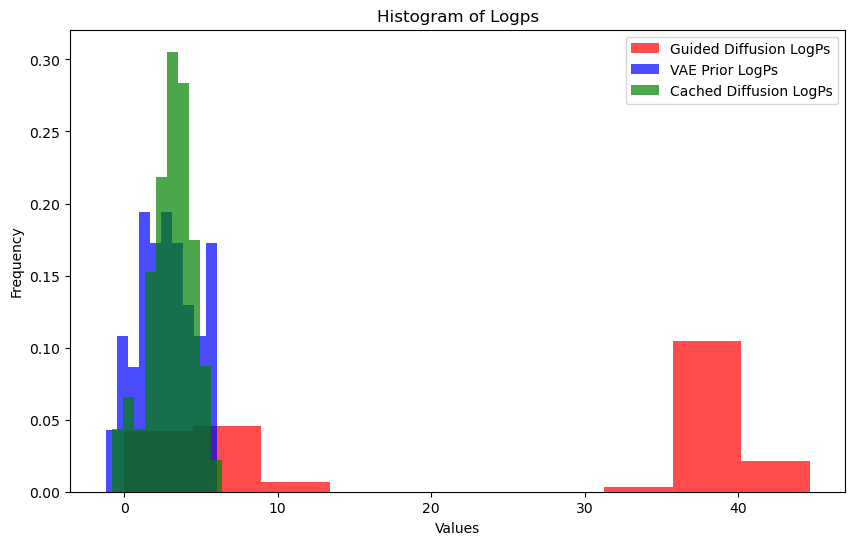

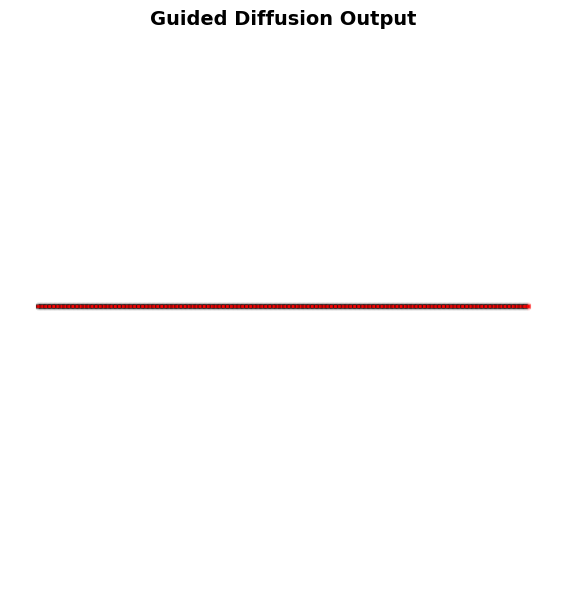

SMILES: O=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C=C
LogP Stats: 
Max LogP: 44.70
Min LogP: 0.00
Avg LogP: 24.82

Stats:
Sample of shape: torch.Size([64, 1, 128]) is different from other with p=0.0000



In [65]:
# LogP Test to check model is working

logp_distribution = Normal(loc=100.0, scale=1.0)
def log_prob_fn_logp(z):
    z = torch.clamp(z, -3.0, 3.0)
    pred_logp = logp_predictor(z)
    log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)
    assert(log_prob.shape == (1, ))
    return log_prob

cond_fn_logp = gd.get_cond_fn(
    log_prob_fn=log_prob_fn_logp, 
    latent_dim=latent_dim,
    clip_grad=False
)

z_diffusion_cached= sample(batch_size=64)
z = diffusion.sample(batch_size=64, cond_fn=cond_fn_logp)
vis.display_logp_info(z, z_diffusion_cached=z_diffusion_cached, vae=selfies_vae)


In [9]:
import numpy as np
import time
import math
from multiprocessing.pool import ThreadPool
import itertools
import time
from guacamol import standard_benchmarks
from rdkit.Contrib.SA_Score import sascorer

try:  # for tdc docking
    from tdc import Oracle
except:
    print("Warning: Failed to import tdc docking oracle, only needed for molecule docking tasks")

from rdkit import Chem
from rdkit.Chem import Crippen
import networkx as nx
from rdkit.Chem import rdmolops
from rdkit.Chem.QED import qed
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import FoldFingerprint
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

from guacamol import standard_benchmarks

med1 = standard_benchmarks.median_camphor_menthol()  #'Median molecules 1'
med2 = standard_benchmarks.median_tadalafil_sildenafil()  #'Median molecules 2',
pdop = standard_benchmarks.perindopril_rings()  # 'Perindopril MPO',
osmb = standard_benchmarks.hard_osimertinib()  # 'Osimertinib MPO',
adip = standard_benchmarks.amlodipine_rings()  # 'Amlodipine MPO'
siga = standard_benchmarks.sitagliptin_replacement()  #'Sitagliptin MPO'
zale = standard_benchmarks.zaleplon_with_other_formula()  # 'Zaleplon MPO'
valt = standard_benchmarks.valsartan_smarts()  #'Valsartan SMARTS',
dhop = standard_benchmarks.decoration_hop()  # 'Deco Hop'
shop = standard_benchmarks.scaffold_hop()  # Scaffold Hop'
rano = standard_benchmarks.ranolazine_mpo()  #'Ranolazine MPO'
fexo = standard_benchmarks.hard_fexofenadine()  # 'Fexofenadine MPO'... 'make fexofenadine less greasy'


guacamol_objs = {
    "med1": med1,
    "pdop": pdop,
    "adip": adip,
    "rano": rano,
    "osmb": osmb,
    "siga": siga,
    "zale": zale,
    "valt": valt,
    "med2": med2,
    "dhop": dhop,
    "shop": shop,
    "fexo": fexo,
}


GUACAMOL_TASK_NAMES = ["med1", "pdop", "adip", "rano", "osmb", "siga", "zale", "valt", "med2", "dhop", "shop", "fexo"]


def smile_is_valid_mol(smile):
    if smile is None or len(smile) == 0:
        return False
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return False
    return True


def smile_to_guacamole_score(obj_func_key, smile):
    if smile is None or len(smile) == 0:
        return None
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    func = guacamol_objs[obj_func_key]
    score = func.objective.score(smile)
    if score is None:
        return None
    if score < 0:
        return None
    return score


def smile_to_rdkit_mol(smile):
    return Chem.MolFromSmiles(smile)


vectorized_smiles_arr_to_mols_arr = np.vectorize(smile_to_rdkit_mol)


def smile_to_QED(smile):
    """
    Computes RDKit's QED score
    """
    if smile is None:
        return None
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    qed_score = qed(mol)
    return qed_score


def smile_to_sa(smile):
    """Synthetic Accessibility Score (SA):
    a heuristic estimate of how hard (10)
    or how easy (1) it is to synthesize a given molecule."""
    if smile is None:
        return None
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    return sascorer.calculateScore(mol)


def smile_to_penalized_logP(smile):
    """calculate penalized logP for a given smiles string"""
    if smile is None:
        return None
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    logp = Crippen.MolLogP(mol)
    sa = sascorer.calculateScore(mol)
    if sa is None:
        return None
    cycle_length = _cycle_score(mol)
    """
    Calculate final adjusted score.
    These magic numbers are the empirical means and
    std devs of the dataset.

    I agree this is a weird way to calculate a score...
    but this is what previous papers did!
    """
    score = (
        (logp - 2.45777691) / 1.43341767 + (-sa + 3.05352042) / 0.83460587 + (-cycle_length - -0.04861121) / 0.28746695
    )
    return max(score, -float("inf"))


def _cycle_score(mol):
    cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(mol)))
    if len(cycle_list) == 0:
        cycle_length = 0
    else:
        cycle_length = max([len(j) for j in cycle_list])
    if cycle_length <= 6:
        cycle_length = 0
    else:
        cycle_length = cycle_length - 6
    return cycle_length


def setup_tdc_oracle(protien_name):
    oracle = Oracle(name=protien_name)
    return oracle


def smile_to_tdc_docking_score(smiles_str, tdc_oracle, max_smile_len=600, timeout=600):
    # goal of function:
    #          return docking score (score = tdc_oracle(smiles_str) ) iff it can be computed within timeout seconds
    #           otherwise, return None
    if not smile_is_valid_mol(smiles_str):
        return None
    smiles_str = Chem.CanonSmiles(smiles_str)
    if len(smiles_str) > max_smile_len:
        return None
    start = time.time()

    def get_the_score(smiles_str):
        docking_score = tdc_oracle(smiles_str)
        return docking_score

    pool = ThreadPool(1)

    async_result = pool.apply_async(get_the_score, (smiles_str,))
    from multiprocessing.context import TimeoutError

    try:
        ret_value = async_result.get(timeout=timeout)
    except Exception as e:
        print("Error occurred getting score from smiles str::", smiles_str, e)
        # print('TimeoutError encountered getting docking score for smiles_str:', smiles_str)
        ret_value = None

    print(f"getting docking score: {ret_value} from protein took {time.time() - start} seconds")
    return ret_value


def smiles_to_desired_scores(smiles_list, task_id="logp"):
    scores = []
    for smiles_str in smiles_list:
        if task_id == "logp":
            score_ = smile_to_penalized_logP(smiles_str)
        elif task_id == "qed":
            score_ = smile_to_QED(smiles_str)
        else:  # otherwise, assume it is a guacamol task
            score_ = smile_to_guacamole_score(task_id, smiles_str)
        if (score_ is not None) and (math.isfinite(score_)):
            scores.append(score_)
        else:
            scores.append(np.nan)

    return np.array(scores)


def get_fingerprint_similarity(smile1, smile2):
    mol1 = Chem.MolFromSmiles(smile1)
    mol2 = Chem.MolFromSmiles(smile2)
    if (mol1 is None) or (mol2 is None):
        print("one of the input smiles is not a valid molecule!")
        return None
    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    fps = DataStructs.FingerprintSimilarity(fp1, fp2)
    return fps
    # TIMING get_fingerprint_similarity:
    # time to convert each smile to fp: 0.0023517608642578125 (SMILE --> MOL --> FP)
    # time to compute FPS from fp1, fp2: 0.000148  (fps = DataStructs.FingerprintSimilarity(fp1,fp2) )
    # Percentage of Time Used to convert each smile to fp: 0.9408622663105685
    # Percentage of Time Used Compute FPS:0.05913773368943152
    # total time: 0.0024995803833007812


def get_fp_and_fpNbits_from_smile(smile1):
    mol1 = Chem.MolFromSmiles(smile1)
    if mol1 is None:
        return (None, None)
    fp1 = FingerprintMols.FingerprintMol(mol1)
    sz1 = fp1.GetNumBits()
    return (fp1, sz1)


def get_fps_efficient(fp1, sz1, fp2, sz2):
    # https://github.com/rdkit/rdkit/blob/master/rdkit/DataStructs/__init__.py
    if sz1 < sz2:
        fp2 = FoldFingerprint(fp2, sz2 // sz1)
    elif sz2 < sz1:
        fp1 = FoldFingerprint(fp1, sz1 // sz2)
    return TanimotoSimilarity(fp1, fp2)  # FPS!


def get_fps_to_list_of_targets(fp1, sz1, target_fps, target_szs):
    return np.array([get_fps_efficient(fp1, sz1, target_fps[ix], target_szs[ix]) for ix in range(len(target_fps))])
    # TEST SCRIPT:
    # target_fps = [FingerprintMols.FingerprintMol(Chem.MolFromSmiles(smile1)) for smile1 in train_smiles[0:100_000] ]
    # target_szs = [fp.GetNumBits() for fp in target_fps]
    # et_fps_to_list_of_targets(fp1, sz1, target_fps, target_szs)


def efficient_get_all_pairwise_fps(fp_nbits_list):
    all_pairs = list(itertools.combinations(fp_nbits_list, r=2))
    fpss = []
    for fps_nbits_pair in all_pairs:
        fp1_nb1, fp2_nb2 = fps_nbits_pair[0], fps_nbits_pair[1]
        fpss.append(get_fps_efficient(fp1_nb1[0], fp1_nb1[1], fp2_nb2[0], fp2_nb2[1]))
    return np.array(fpss)


def get_all_pairwise_fps(smiles_list, return_fp_nbits=False):
    mol_list = [Chem.MolFromSmiles(smile1) for smile1 in smiles_list]
    if None in mol_list:  # if one of smiles can't convert to mol
        if return_fp_nbits:
            return None, None
        return None
    fp_list = [FingerprintMols.FingerprintMol(mol1) for mol1 in mol_list]
    sz_list = [fp1.GetNumBits() for fp1 in fp_list]
    if return_fp_nbits:
        fps_nbits = []
        for fp, sz in zip(fp_list, sz_list):
            fps_nbits.append((fp, sz))
    all_idxs = [i for i in range(len(smiles_list))]
    all_pairs_idxs = list(itertools.combinations(all_idxs, r=2))
    fpss = []
    for ix_pair in all_pairs_idxs:
        ix1, ix2 = ix_pair[0], ix_pair[1]
        fps = get_fps_efficient(fp_list[ix1], sz_list[ix1], fp_list[ix2], sz_list[ix2])
        if fps is not None:
            fpss.append(fps)
    if return_fp_nbits:
        return np.array(fpss), fps_nbits
    return np.array(fpss)


def get_pairwise_edit_distances(smiles_list1, smiles_list2):
    edit_dists = []
    for s1, s2 in zip(smiles_list1, smiles_list2):
        edit_dists.append(smiles_edit_distance(s1, s2))
    return np.array(edit_dists)


def get_all_pairwise_edit_dists(smiles_list):
    all_idxs = [i for i in range(len(smiles_list))]
    all_pairs_idxs = list(itertools.combinations(all_idxs, r=2))
    dists = []
    for ix_pair in all_pairs_idxs:
        ix1, ix2 = ix_pair[0], ix_pair[1]
        edit_dist = smiles_edit_distance(smiles_list[ix1], smiles_list[ix2])
        dists.append(edit_dist)
    return np.array(dists)


def smiles_edit_distance(s1, s2):
    """Returns Levenshtein Edit Distance btwn two Smiles strings"""

    # Must first Canonize so they are comparable
    s1 = Chem.CanonSmiles(s1)
    s2 = Chem.CanonSmiles(s2)

    m = len(s1) + 1
    n = len(s2) + 1
    tbl = {}
    for i in range(m):
        tbl[i, 0] = i
    for j in range(n):
        tbl[0, j] = j
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            tbl[i, j] = min(tbl[i, j - 1] + 1, tbl[i - 1, j] + 1, tbl[i - 1, j - 1] + cost)

    return tbl[i, j]


def check_smiles_equivalence(smile1, smile2):
    if smile1 is None or smile2 is None:
        print("one of smiles strings is NONE")
        return False
    smile1 = Chem.CanonSmiles(smile1)
    smile2 = Chem.CanonSmiles(smile2)
    return smile1 == smile2

In [4]:
from botorch.optim import optimize_acqf
from botorch.acquisition import qLogExpectedImprovement, qExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.utils.transforms import normalize, unnormalize
from torch.optim import SGD
from botorch import fit_gpytorch_mll

# Loads 20,000 guacamol molecule latents
LATENT_DATASET_LOCATION = "data/latents_pair_dataset_1"
X_all_data = torch.load(LATENT_DATASET_LOCATION, weights_only=True)

def print_dataset_stats(X, Y):
    print(f"--- Dataset Stats ---")
    print(f"Min Obj Value: {Y.min():.4f}")
    print(f"Max Obj Value: {Y.max():.4f}")

In [6]:
obj_fun = lambda z: torch.tensor(smiles_to_desired_scores(decode(z), task_id='rano')).reshape(-1, 1)
latent_dim = 128

bounds = torch.tensor([[-3.0] * latent_dim, [3.0] * latent_dim], device=device, dtype=torch.float64)
unit_bounds = torch.tensor([[0.0] * latent_dim, [1.0] * latent_dim], device=device, dtype=torch.float64)
def get_initial_data(num_points: int = 100):
    Xs = X_all_data[:num_points].reshape(-1, latent_dim).clone().double().to(device)
    Ys = obj_fun(Xs).reshape(-1, 1).clone().double().to(device)
    return Xs, Ys

In [7]:
BATCH_SIZE = 5
NUM_RESTARTS = 10
RAW_SAMPLES = 256
N_BATCH = 100

def get_fitted_model(train_x, train_obj, state_dict=None):
    model = SingleTaskGP(
        train_X=normalize(train_x, bounds),
        train_Y=train_obj,
    )
    if state_dict is not None:
        model.load_state_dict(state_dict)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_mll(mll)
    return model

def optimize_acqf_and_get_observation(acq_func):
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=unit_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES
    )

    new_x = unnormalize(candidates.detach(), bounds=bounds).to(device)
    new_obj = obj_fun(new_x).to(device)
    return new_x, new_obj



In [10]:
train_x, train_obj = get_initial_data(num_points=5_000)
print_dataset_stats(train_x, train_obj)

state_dict = None

num_oracle_calls_list = []
best_value_list = []

print(f"\nRunning BO ")

for iteration in range(N_BATCH):
    model = get_fitted_model(
        train_x=train_x,
        train_obj=train_obj,
        state_dict=state_dict,
    )

    # define the qNEI acquisition function
    qEI = qExpectedImprovement(
        model=model, best_f=train_obj.max()
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    num_oracle_calls_list.append(train_x.shape[0])
    best_value_list.append(best_value)

    print(f"[{train_x.shape[0]}] Best Value: {best_value:.2f}")
    state_dict = model.state_dict()

    


--- Dataset Stats ---
Min Obj Value: 0.0000
Max Obj Value: 0.7652

Running BO 


/home/alden/miniconda3/envs/pytorch-cuda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


KeyboardInterrupt: 

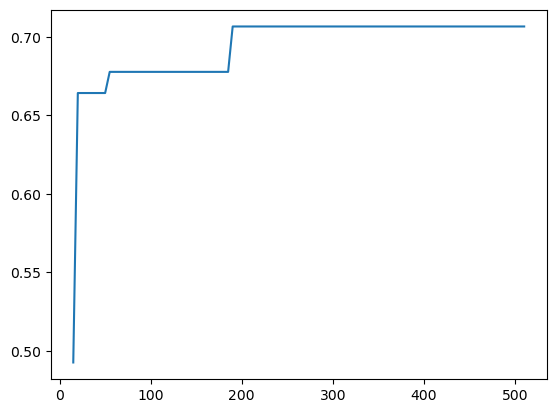

In [102]:
plt.plot(num_oracle_calls_list, best_value_list)

In [ ]:
def batch_sample_random():
    return obj_fun(sample_random(batch_size=BATCH_SIZE))

random_ys_list = []

for i in range(10):
    random_ys = torch.zeros(size=(500, 1))

    for batch_idx in range(N_BATCH):
        random_y = batch_sample_random()

        idx = batch_idx * BATCH_SIZE
        random_ys[idx:idx+BATCH_SIZE] = random_y
    random_ys_list.append(random_ys)

def batch_sample_diffusion():
    return obj_fun(sample(batch_size=BATCH_SIZE))

diffusion_ys_list = []

for i in range(10):
    diffusion_ys = torch.zeros(size=(500, 1))

    for batch_idx in range(N_BATCH):
        diffusion_y = batch_sample_diffusion()

        idx = batch_idx * BATCH_SIZE
        diffusion_ys[idx:idx+BATCH_SIZE] = diffusion_y
    diffusion_ys_list.append(diffusion_ys)

DDIM Sampling Loop Time Step: 100%|██████████| 50/50 [00:00<00:00, 97.63it/s]


In [213]:
def plot_oracle_optimization(tensor_list_of_lists, labels, color=['Blue', 'Red', 'Green', 'Purple', 'Yellow', 'Orange'], title="Oracle Call Optimization Progress"):
    
    plt.figure(figsize=(12, 8))
    
    plt.xlabel('Oracle Call Number', fontsize=12)
    plt.ylabel('Best Value Found', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')

    for i, tensor_list in enumerate(tensor_list_of_lists):
        runs = []
        for _, tensor in enumerate(tensor_list):
            runs.append(np.nan_to_num(tensor.cpu().squeeze().numpy()))  # Remove the dimension of size 1
        
        runs = np.array(runs)  # Shape: (10, 500)

        print(runs[0].shape)
    
        cumulative_best = np.maximum.accumulate(runs, axis=1)

        mean_best = np.mean(cumulative_best, axis=0)
        std_best = np.std(cumulative_best, axis=0)
    
        # x-axis
        x = np.arange(1, 501)
        plt.plot(x, mean_best, 'b-', linewidth=2, color=color[i], label=labels[i], alpha=0.8)
        plt.fill_between(x, mean_best - std_best, mean_best + std_best, 
                        alpha=0.3, color=color[i], label='±1 Standard Deviation')
    
    
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()



(500,)
(500,)
(500,)


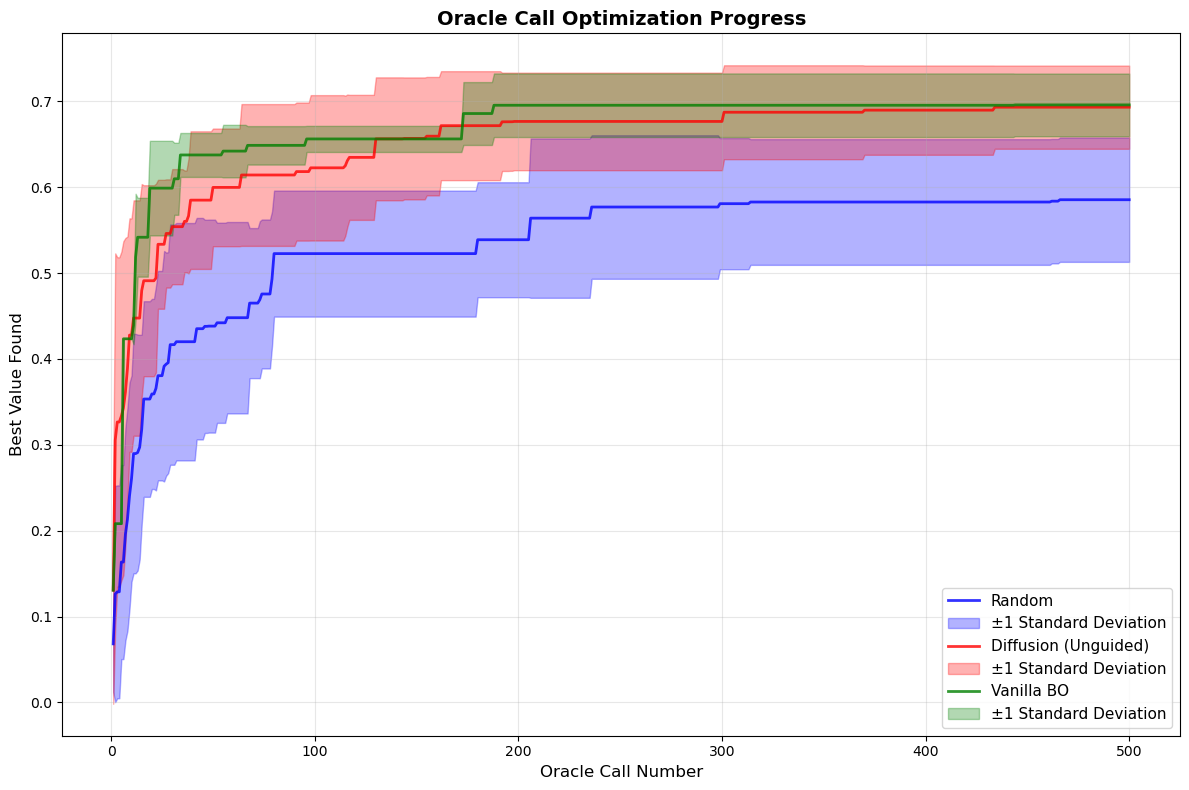

In [214]:
plot_oracle_optimization(tensor_list_of_lists=[random_ys_list, diffusion_ys_list, bayesopt_ys_list], labels=['Random', 'Diffusion (Unguided)', 'Vanilla BO'])


In [138]:
diffusion_ys_list[0].shape

torch.Size([500, 1])